# Importing libraries

In [14]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Loading data

In [2]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True) 

Running above line downloads the dataset on your machine in user->tensorflow_datasets. Parameter as_supervised loads data into two tuple structure [input, targets] useful for supervised learning. Parameter with_info provides metadata of data like version, features.

In [3]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# Calculating number of data points for validation and test sets

In [4]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = 0.1 * mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

# Scaling data to range between 0 and 1

In [5]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    return image, label

scaled_train_and_validation_data = mnist_train.map(scale)
scaled_test_data = mnist_test.map(scale)

Function map applies scale to every data point in mnist_train.

# Shuffling

We want to shuffle because if we have groups of data in sequence(descending order) then our SGD batches may have one type of target dominating over others while optimizing. Uniform shuffling is being done.

In [6]:
BUFFER_SIZE = 10000 # When we have enormous we may not be able to shuffle in one operation hence buffer
shuffled_train_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# Creating train and validation set

In [7]:
validation_data = shuffled_train_validation_data.take(num_validation_samples)
train_data = shuffled_train_validation_data.skip(num_validation_samples)

# Creating batches of 100 from train_data
BATCH_SIZE = 100
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples) # no batching
test_data = scaled_test_data.batch(num_test_samples) # no batching

We don't need to batch validation set as we are not backpropogating during validation. Remember our weights will be adjusted only once per batch which in our case will happen after 100 samples and not after every sample. We do need to batch validation/test data hence we setting batch size as number of values.

In [8]:
validation_inputs, validation_targets = next(iter(validation_data))

# Creating the model

In [9]:
input_size = 784
hidden_layer_size = 100
output_size = 10

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training model

In [10]:
NUM_EPOCHS = 5

model.fit(train_data, epochs=NUM_EPOCHS, 
          validation_data=(validation_inputs, validation_targets),validation_steps=1, verbose=2)  

Epoch 1/5
540/540 - 8s - loss: 0.3275 - accuracy: 0.9070 - val_loss: 0.1819 - val_accuracy: 0.9510
Epoch 2/5
540/540 - 8s - loss: 0.1374 - accuracy: 0.9589 - val_loss: 0.1322 - val_accuracy: 0.9637
Epoch 3/5
540/540 - 7s - loss: 0.0967 - accuracy: 0.9702 - val_loss: 0.1004 - val_accuracy: 0.9702
Epoch 4/5
540/540 - 7s - loss: 0.0731 - accuracy: 0.9781 - val_loss: 0.0834 - val_accuracy: 0.9773
Epoch 5/5
540/540 - 7s - loss: 0.0601 - accuracy: 0.9819 - val_loss: 0.0714 - val_accuracy: 0.9802


# Testing

In [11]:
test_loss, test_accuracy = model.evaluate(train_data)
print(test_loss, test_accuracy)

    540/Unknown - 7s 13ms/step - loss: 0.0462 - accuracy: 0.98610.0462475392881229 0.9861481


Since our validation accuracy and test accuracy are similar we haven't overfit.

# Predicting with individual image from test data

In [12]:
img = next(iter(test_data))[0][1]
model.predict([[img]])

array([[1.7133420e-05, 4.4041303e-06, 9.9902487e-01, 6.0444517e-04,
        1.6176245e-06, 1.1704251e-07, 6.3686969e-07, 2.0527669e-04,
        1.3879585e-04, 2.6991604e-06]], dtype=float32)

Highest value in above array is for index 2 which tells us that our prediction is 2.

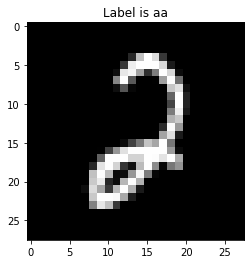

In [15]:
pixels = np.array(img).reshape((28, 28))
plt.title('Label is {label}'.format(label="aa"))
plt.imshow(pixels, cmap='gray')
plt.show()

Plotting the input image, we can see that image too is of digit 2 and our model was able to identify this successfully.